<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/playground_series_s3e21/undraw_Programming_re_kg9v.png" width=600px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Playground Series S3E21 - Dissolved O2 in River Water</p>


In [1]:
# %load ../general_settings.py
# !pip install -q -U numpy==1.22.4
import glob
import os
import sys
import shutil
import subprocess
import warnings
from array import array
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
if ON_KAGGLE:
    warnings.filterwarnings("ignore")

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns
import shap

# import swifter
from colorama import Fore, Style
from IPython.core.display import HTML, display_html
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from shap import explainers, maskers

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
YELLOW = Style.BRIGHT + Fore.YELLOW
RESET = Style.RESET_ALL

FONT_COLOR = "#4A4B52"
BACKGROUND_COLOR = "#FFFCFA"

CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": "background-color: #FFFCFA",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": "color: #4A4B52; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette("#BAB8B8", as_cmap=True)

MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 11,
    "axes.labelpad": 15,
    # "axes.labelweight": "bold",
    "axes.titlesize": 14,
    # "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "axes.grid": False,
    "axes.facecolor": BACKGROUND_COLOR,
    "xtick.labelsize": 11,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 11,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 11,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.set_theme(rc=MY_RC)

# Utility functions.
def download_from_kaggle(expr: list[str], directory: Path | None = None) -> None:
    if directory is None:
        directory = Path("data")
    if not isinstance(directory, Path):
        raise TypeError("The `directory` argument must be `Path` instance!")
    match expr:
        case ["kaggle", _, "download", *args] if args:
            directory.parent.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (directory / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, directory)
                shutil.move(filename, directory)
        case _:
            raise SyntaxError("Invalid expression!")


def interpolate_color(color1, color2, t):
    r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
    r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
    r = int(r1 + (r2 - r1) * t)
    g = int(g1 + (g2 - g1) * t)
    b = int(b1 + (b2 - b1) * t)
    return f"#{r:02X}{g:02X}{b:02X}"


def get_interpolated_colors(color1, color2, num_colors=2):
    """Return `num_colors` interpolated beetwen `color1` and `color2`.
    Arguments need to be HEX."""
    num_colors = num_colors + 2
    return [interpolate_color(color1, color2, i / (num_colors - 1)) for i in range(num_colors)]


# Html `code` block highlight. Must be included at the end of all imports!
HTML(
    """
<style>
code {
    background: rgba(42, 53, 125, 0.10) !important;
    border-radius: 4px !important;
}
a {
    color: rgba(123, 171, 237, 1.0) !important;
}
ol.numbered-list {
  counter-reset: item;
}
ol.numbered-list li {
  display: block;
}
ol.numbered-list li:before {
  content: counters(item, '.') '. ';
  counter-increment: item;
}
</style>
"""
)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Competition Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The dataset for this competition is a synthetic dataset based off of the <a href="https://www.kaggle.com/datasets/vbmokin/dissolved-oxygen-prediction-in-river-water"><b>Dissolved oxygen prediction in river water dataset</b></a>. As we can read in the original dataset description: <i>This dataset has data of the 5 indicators of river water quality from 8 consecutive stations of the state water monitoring system. It's should predict the value in the eighth station by the first seven stations. The numbering of stations in the dataset is done from the target station upstream, ie closest to it - first, upstream - second, etc. Data are average monthly. The number of observations on stations is different (from 4 to about 20 years). Training and test data are chosen so that the percentage of non-NA values on stations with long and short series data is approximately the same.</i>
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Task</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This is a different type of competition. <b>Instead of submitting predictions, your task is to submit a dataset that will be used to train a random forest regressor model.</b> Your submission will be used as a training dataset to train the following model and make predictions against a hidden test dataset:<br><br>
    <code style="
        display: block;
        white-space: pre-wrap;
    ">
    from sklearn.ensemble import RandomForestRegressor<br>
    y_train = train.pop("target")  # train is your submission!
    rf = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)
    rf.fit(train, y_train)
    y_hat = rf.predict(test)  # test set is hidden from you
    </code><br>
    The competition evaluation metric is <a href="https://en.wikipedia.org/wiki/Root-mean-square_deviation"><b>RMSE</b></a> (root mean squared error):
    \[\textrm{RMSE} = \sqrt{\frac{1}{N}\sum_{i=1}^N \left(y_i - \hat{y}_i\right)^2},\]
    where $y_i$ is the actual value and $\hat{y}_i$ is the predicted value, for the sample $i$.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Table of Contents</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The table of contents provides pleasurable navigation through the whole notebook. You can easily navigate through sections and return to TOC. If you want quickly find out something about the dataset, just read the first section, i.e. <b>Quick Overview</b>.
</p>

<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #FF7F51;
    border-radius: 2px;
    border: 1px solid #FF7F51;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#quick_overview"><span style="color: #F2F2F0">Quick Overview</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#data_reading_and_features_description"><span style="color: #F2F2F0">Data Reading &amp; Features Description</span></a></li>
        <li><a href="#basic_numerical_relations_summaries"><span style="color: #F2F2F0">Basic Numerical Relations &amp; Summaries</span></a></li>
        <li><a href="#feature_distributions"><span style="color: #F2F2F0">Feature Distributions</span></a></li>
        <li><a href="#quick_summary"><span style="color: #F2F2F0">Quick Summary</span></a></li>
    </ol>
    </li>
    <li><a href="#feature_importances"><span style="color: #F2F2F0">Feature Importances</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#decision_process_with_decision_tree"><span style="color: #F2F2F0">Decision Process with Decision Tree</span></a></li>
        <li><a href="#random_variables_permutation_test"><span style="color: #F2F2F0">Random Variables &amp; Permutation Test</span></a></li>
        <li><a href="#partial_dependence_for_features_of_interest"><span style="color: #F2F2F0">Partial Dependence for Features of Interest</span></a></li>
        <li><a href="#feature_importance_with_shap"><span style="color: #F2F2F0">Feature Importance with SHAP</span></a></li>
        <li><a href="#feature_importances_summary"><span style="color: #F2F2F0">Feature Importances Summary</span></a></li>
    </ol>
    </li>
    <li><a href="#outliers_detection"><span style="color: #F2F2F0">Outliers Detection</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#isolation_forest_vs_performance"><span style="color: #F2F2F0">Isolation Forest vs Performance</span></a></li>
        <li><a href="#most_problematic_samples"><span style="color: #F2F2F0">Most Problematic Samples</span></a></li>
    </ol>
    </li>
    <li><a href="#summary"><span style="color: #F2F2F0">Summary</span></a>
</ol>
</blockquote>


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Quick Overview</span></b><a class="anchor" id="quick_overview"></a> [↑](#top)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, I provide a quick overview of the dataset. More detailed analysis will be done in subsequent sections.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Reading &amp; Features Description</span></b><a class="anchor" id="data_reading_and_features_description"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>Let's get started with loading the dataset and explaining what available features mean.</b>
</p>

In [2]:
competition = "playground-series-s3e21"
expr = f"kaggle competitions download -c {competition}".split()

if not ON_KAGGLE:
    download_from_kaggle(expr)
    train_path = "data/sample_submission.csv"
else:
    train_path = f"/kaggle/input/{competition}/sample_submission.csv"

train = pd.read_csv(train_path, index_col="id", engine="pyarrow")  # .rename(columns=str.title)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Insight</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    I prefer to capitalize data frame columns because sometimes they can contain features named the same way as some methods. Since I like to refer to columns as an attribute (with a dot), it's better to provide capitalized names. However, in the case of this dataset, it's not needed.
</p>

In [3]:
train.head().style.set_table_styles(DF_STYLE).format(precision=5)


,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8.59000,7.50000,9.00000,9.54500,9.26500,8.11000,8.43000,7.15000,0.18000,0.20000,0.65000,14.51500,5.84500,1.28500,0.42900,0.03000,0.05000,0.06400,0.73000,1.07500,0.05600,0.56700,0.40000,1.50000,1.56000,19.35500,4.95000,1.73000,1.80000,4.80000,3.15000,10.66500,10.46500,16.64500,5.75000,10.37000
1,9.10000,13.53300,40.90000,8.77000,9.26500,6.01500,10.07000,7.15000,1.10700,1.02700,1.84800,8.62500,12.17500,0.28000,0.44000,0.08900,1.36000,0.06400,0.90200,1.45400,0.05600,0.19000,2.34700,5.10500,2.09500,19.35500,20.05000,9.53000,7.69500,4.55000,6.95000,2.04000,5.20000,5.72500,2.95000,2.23000
2,8.21000,3.71000,5.42000,8.77000,9.26500,4.55000,10.07000,7.15000,0.02000,0.02000,0.65000,17.14400,24.64500,0.38000,0.44000,0.06000,0.05000,0.08200,0.90200,2.02500,0.05600,0.56700,1.70000,1.70000,3.96000,4.90000,4.58000,3.02500,3.96000,4.93500,4.95000,4.72500,6.07500,6.75000,3.50000,3.17000
3,8.39000,8.70000,8.10000,9.50000,9.20000,5.20000,8.67000,6.67000,0.28000,0.27000,1.73000,3.87000,8.41000,1.48000,1.38000,0.05000,0.05000,0.07000,0.53000,1.74000,0.05000,0.06400,1.50000,1.50000,2.02000,3.96000,8.45000,2.07000,1.73000,6.30000,4.70000,3.50000,6.20000,8.67000,2.90000,7.37000
4,8.07000,8.05000,8.65000,7.96000,9.26500,3.29000,10.07000,7.15000,0.36000,0.43500,0.65000,3.85000,5.84500,0.28000,0.44000,0.10500,0.11500,0.07400,1.25200,1.07500,0.07100,0.19000,1.05000,1.15000,2.09500,3.90200,2.02000,1.73000,0.76000,4.80000,4.97000,3.95000,2.80000,8.40000,3.50000,3.90000


In [4]:
train.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 0 to 3499
Columns: 36 entries, target to BOD5_7
dtypes: float64(36)
memory usage: 1011.7 KB


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Features Description</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Features are divided into five major indicators of river water quality. These are:
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <li><code>O2-Variables</code> - Dissolved oxygen (O2) is measured in mgO2/cub. dm (ie milligrams of oxygen (O2) in the cubic decimeter).</li>
    <li><code>NH4-Variables</code> - Ammonium ions (NH4) concentration is measured in mg/cub. dm (ie milligrams in the cubic decimeter).</li>
    <li><code>NO2-Variables</code> - Nitrite ions (NO2) concentration is measured in mg/cub. dm (ie milligrams in the cubic decimeter).</li>
    <li><code>NO3-Variables</code> - Nitrate ions (NO3) concentration is measured in mg/cub. dm (ie milligrams in the cubic decimeter).</li>
    <li><code>BOD5-Variables</code> - Biochemical oxygen demand, which is determined in 5 days ("BOD5" or "BOD"). BOD5 is measured in mgO/cub. dm (ie milligrams of oxygen in the cubic decimeter).</li>
</ul>
<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Each of the above groups is divided by several sub-features, i.e. $1$ - $7$ - values of monthly averaged data in stations $1$ - $7$ (in seven stations located from the target station upstream). Moreover, the <code>target</code> is a value of monthly averaged data of O2 in the target station in mgO2/cub. dm. <b>The dataset is composed of $3500$ samples and $35$ features, which gives us $100$ samples per dimension.</b>
</p>

In [5]:
assert len(train.columns) == 5 * 7 + 1  # Five major indicators from 7 stations and the target.


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Insight</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Reading the description of the original dataset, we know that the numbering of stations in the dataset is done from the target station upstream, i.e. closest to it - first, upstream - second, etc. <b>The assignment in the original dataset is to predict O2 values in the last station, in this case, station $0$. The water flows from station $2$ to $1$ and from $1$ to $0$. Therefore, O2 features should be good predictors for the task, shouldn't they?</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Basic Numerical Relations &amp; Summaries</span></b><a class="anchor" id="basic_numerical_relations_summaries"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <b>Now we're going to look more closely at numerical properties and dependencies. Let's have a look at the target variable distribution first.</b>
</p>

In [6]:
target = train.target
Q1, Q3 = np.percentile(target, 25), np.percentile(target, 75)

fig = px.histogram(
    x=target,
    labels={"x": "Target"},
    marginal="box",
    histnorm="probability density",
    title="Monthly Averaged Data of O\u2082 in Target Station<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "In the dataset, two significantly higher values have been observed. Outliers?</span>",
    color_discrete_sequence=["#4A4B52"],
    opacity=0.75,
    height=540,
    width=840,
)
fig.add_annotation(
    x=20,
    y=0.6,
    align="left",
    xanchor="left",
    text=f"<b>The major (75%) of the target values are in ({Q1:.2f}, {Q3:.2f}) range.</b>",
    showarrow=False,
)
fig.add_vrect(x0=Q1, x1=Q3, line_width=0, fillcolor="#FF7F51", opacity=0.25, row=1)
fig.add_vline(x=Q1, line_width=2, line_dash="dash", line_color="#4A4B52", row=1)
fig.add_vline(x=Q3, line_width=2, line_dash="dash", line_color="#4A4B52", row=1)
fig.update_yaxes(title="Probability Density", row=1)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    bargap=0.25,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Target Distribution</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The <code>target</code> feature has an extremely long tail, with at least two significant observations responsible for this state. <b>Perhaps we can reject these two samples, provided that we suppose the test dataset hasn't got observations like that. Otherwise, we should keep them.</b> The whole distribution is between $1.30$ and $65.93$ but $75$% of it is in the $(7.47, 9.11)$ range, so maybe be we can clip it.<br><br>
    Let's get to the basic numerical summary of the dataset. Firstly, let's see the diversity of the dataset, i.e. missing values, unique values and their frequency.
</p>

In [7]:
missing_vals = train.isna().sum()

unique_vals = train.apply(lambda col: len(col.unique()))
most_freq_count = train.apply(lambda col: col.value_counts().iloc[0])
most_freq_val = train.mode().T.squeeze()

unique_ratio = unique_vals / len(train)
freq_count_ratio = most_freq_count / len(train)

basic_summary = pd.DataFrame(
    {
        "MissingValues": missing_vals,
        "UniqueValues": unique_vals,
        "UniqueValuesRatio": unique_ratio,
        "MostFreqValueCount": most_freq_count,
        "MostFreqValueCountRatio": freq_count_ratio,
        "MostFreqValue": most_freq_val,
    }
)

basic_summary.style.set_table_styles(DF_STYLE).background_gradient(DF_CMAP).format(
    {"UniqueValuesRatio": "{:.1%}", "MostFreqValueCountRatio": "{:.1%}"}, precision=3
)


,MissingValues,UniqueValues,UniqueValuesRatio,MostFreqValueCount,MostFreqValueCountRatio,MostFreqValue
target,0,462,13.2%,106,3.0%,8.080
O2_1,0,329,9.4%,250,7.1%,7.500
O2_2,0,258,7.4%,321,9.2%,8.500
O2_3,0,235,6.7%,900,25.7%,9.545
O2_4,0,241,6.9%,677,19.3%,9.265
O2_5,0,317,9.1%,430,12.3%,6.015
O2_6,0,238,6.8%,844,24.1%,8.980
O2_7,0,303,8.7%,791,22.6%,7.150
NH4_1,0,152,4.3%,483,13.8%,0.300
NH4_2,0,157,4.5%,781,22.3%,0.200


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Unique &amp; Most Frequent Values</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As we know, in the dataset, there are $3500$ samples, but <b>the above table shows us how little we have unique values there. Probably, the synthetic data generation process is liable for that.</b> The most diverse feature is the <code>target</code>, with about $13$% of unique values. On the other hand, <code>NO2-Variables</code> are least varied in the dataset - usually $2$% of unique values. Also interesting are the most frequent values. There we have <code>NH4_7</code> feature, where the only one value consist of above $50$% of that feature. Such weak diversity should be reflected in the distribution plots.<br><br>
    Let's have a look at the numerical summary yet.
</p>

In [8]:
num_descr = (
    train.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
    .T.drop("count", axis=1)
    .rename(columns=str.title)
)

num_descr.style.set_table_styles(DF_STYLE).format(precision=3)


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
target,8.474,1.886,1.300,5.220,6.680,7.470,8.280,9.110,10.590,15.780,65.930
O2_1,8.217,3.041,0.000,4.200,5.300,7.100,7.890,9.100,10.700,14.901,46.950
O2_2,9.292,6.818,0.000,4.699,4.980,7.300,8.300,8.700,13.700,40.900,65.950
O2_3,9.633,1.439,4.900,6.239,7.960,8.770,9.500,9.545,12.070,14.900,16.900
O2_4,8.066,1.464,2.300,5.200,6.100,6.830,7.980,9.265,9.545,11.475,21.800
O2_5,5.672,2.721,0.200,0.636,1.910,4.550,5.800,7.015,9.431,12.030,59.400
O2_6,9.461,1.140,0.000,7.150,8.260,8.980,9.430,10.070,10.440,12.420,40.190
O2_7,6.547,1.663,0.000,2.310,4.158,5.877,6.430,7.150,8.980,11.002,15.900
NH4_1,0.341,0.285,0.020,0.030,0.095,0.214,0.247,0.370,0.897,1.485,4.200
NH4_2,0.398,0.452,0.020,0.020,0.090,0.200,0.245,0.405,1.200,2.600,3.600


In [9]:
train = train[~((np.isclose(train.NH4_5, 3026)) | (np.isclose(train.NO2_4, -4)))]


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Numerical Summary</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    At first sight, there we have a relevant outlier in the <code>NH4_5</code> feature. <b>Even if the 99th percentile is about $30.26$, the maximum value is $3026$, which looks like a multiplication of it. Maybe it's something like an error?</b> As for the rest, there is rather nothing suspect, except <code>NO2_4</code> where the minimal value is $-4$. Another error? It seems that we can remove these samples at once.<br><br>
    As for now let's have a look at the correlation matrix and hierarchical clustering. We should pay special attention to the first column (correlations with the target variable). 
</p>

In [10]:
pearson_corr = train.corr(method="pearson").round(2)
lower_triangular_corr = (
    pearson_corr.mask(np.triu(np.ones_like(pearson_corr, dtype=bool)))
    .dropna(axis="index", how="all")
    .dropna(axis="columns", how="all")
)

color_map = [[0.0, "#FCFCFC"], [0.5, "#4A4B52"], [1.0, "#FF7F51"]]

heatmap = go.Heatmap(
    z=lower_triangular_corr,
    x=lower_triangular_corr.columns,
    y=lower_triangular_corr.index,
    text=lower_triangular_corr.fillna(""),
    texttemplate="%{text}",
    xgap=2,
    ygap=2,
    showscale=True,
    colorscale=color_map,
    colorbar_len=1.02,
    hoverinfo="none",
)
fig = go.Figure(heatmap)
fig.add_annotation(
    x=9.7,
    y=5.3,
    align="left",
    xanchor="left",
    text="<b>Features seem to be rather uncorrelated. We can<br>"
    "distinct only several pairs with high correlation. Probably<br>"
    "majority of features are poor predictors for the target variable.</b>",
    showarrow=False,
)
fig.update_yaxes(tickfont_size=10)
fig.update_xaxes(tickfont_size=10)
fig.update_layout(
    font_color=FONT_COLOR,
    title="Lower Triangular of Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Only O2_1 and O2_2 are somewhat correlated with the Target (O2_0)</span>",
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    width=840,
    height=840,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange="reversed",
)
fig.show()


In [11]:
highest_abs_corr = (
    lower_triangular_corr.abs()
    .unstack()
    .sort_values(ascending=False)  # type: ignore
    .rename("Absolute Pearson Correlation")
    .to_frame()
    .reset_index(names=["Feature 1", "Feature 2"])
)

top_corr = highest_abs_corr[highest_abs_corr["Absolute Pearson Correlation"] > 0.5]
top_corr.style.set_table_styles(DF_STYLE).format(precision=2)


,Feature 1,Feature 2,Absolute Pearson Correlation
0,NH4_1,NH4_2,0.84
1,NO3_1,NO3_2,0.72
2,NO3_6,NO3_7,0.71
3,BOD5_1,BOD5_2,0.64
4,NO3_3,NO3_6,0.64
5,NO3_4,NO3_5,0.57
6,NO3_3,NO3_7,0.56
7,BOD5_6,BOD5_7,0.55
8,NO3_3,NO3_5,0.54


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Correlation Matrix</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As we can see, only <code>O2_1</code> and <code>O2_2</code> are somewhat correlated with the target variable ($0.48$ and $0.22$, respectively). When we think about it, this seems to be logical since these stations are located close to each other, and features represent the same variable as the target one. Also, <code>O2_2</code> is less correlated (this station is further away). <b>I also checked the Spearman correlation, but the situation is similar to the Pearson one, i.e. weakly correlated features.</b> Moreover, most correlated pairs are related to the <code>NO3-Variables</code>.<br><br>
    Since we have the correlation matrix, we can utilise it for another visualisation - hierarchical clustering. Nevertheless, relying on correlations requires an additional step because <b>correlation measures the similarity between variables, but in hierarchical clustering, we need to provide dissimilarity (distance) between them.</b> We can treat dissimilarity as $\textrm{dissimilarity} = 1 - \textrm{abs(correlation)}$. And that's all.
</p>

In [12]:
dissimilarity = 1 - np.abs(pearson_corr)

fig = ff.create_dendrogram(
    dissimilarity,
    labels=pearson_corr.columns,
    orientation="left",
    colorscale=px.colors.sequential.Greys[1:],
    # squareform() returns lower triangular in compressed form - as 1D array.
    linkagefun=lambda x: linkage(squareform(dissimilarity), method="complete"),
)
fig.update_xaxes(showline=False, title="Distance", ticks="", range=[-0.05, 1.05], tickfont_size=10)
fig.update_yaxes(showline=False, ticks="", tickfont_size=10)
fig.update_layout(
    font_color=FONT_COLOR,
    title="Hierarchical Clustering using Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Lack of closely related variables</span>",
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    height=840,
    width=840,
)
fig.update_traces(line_width=1.25, opacity=1)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Hierarchical Clustering</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here, we should remember that we rely on the <b>Pearson</b> correlation. It measures linear dependency, and it's computed on actual values. However, we could have used, for example, the <b>Spearman</b> correlation, which is based on ranks and measures monotonic relations. Apart from that, we chose the <code>complete</code> method in the <code>linkage()</code> function, and if you take a different method, you can get different results.<br><br>
    <b>In this specific example, we see that features are rather in the long distance, which indicates weak relations. Nevertheless, we can spot that clusters are made between variables for nearby located stations (for example third and fourth, first and second, etc.).</b> It means that stations that are close to each other are probably good predictors for the variable from the nearby station. For example, <code>NO3_1</code> is a good predictor for the <code>NO3_2</code>, and so on.<br><br>
    Now, it's time to have a look at scatter plots of the <code>target</code>, <code>O2_1</code> and <code>O2_2</code>.
</p>

In [13]:
fig = make_subplots(rows=1, cols=2, y_title="Target", shared_yaxes=True)
fig.update_annotations(font_size=14)

for col, component in enumerate(("O2_1", "O2_2"), start=1):
    fig.add_scatter(
        name=component,
        x=train[component],
        y=train.target,
        mode="markers",
        marker_size=np.sqrt(train.target + train[component]) * 0.8,
        marker=dict(color="#6B6A6A", symbol="circle", opacity=0.75),
        hovertemplate="Feature=%{x}<br>Target=%{y}",
        showlegend=False,
        row=1,
        col=col,
    )
    fig.add_scatter(
        name="Perfect Covering",
        x=[0, 70],
        y=[0, 70],
        mode="lines",
        marker=dict(color="#FF7F51"),
        showlegend=False,
        row=1,
        col=col,
    )
    fig.update_xaxes(showgrid=False, col=col, title=component, title_font_size=14, range=[0, 70])
    fig.update_yaxes(showgrid=False, col=col, range=[0, 70])

fig.update_layout(
    title="O\u2082 in Target Station vs Highest Correlated Variables<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Only O2_1 (0.48) and O2_2 (0.22) are correlated with the Target (O2_0)</span>",
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    width=840,
    height=480,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Target Pair Plots</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As we can see above, <code>O2_1</code> and <code>O2_2</code> seem to be good predictors for the target variable. <b>However, all of them contain some of outliers. Once more time, we can reject such samples as long as we suppose the test dataset is free from such observations.</b> Moreover, since the plot maintains an equal aspect ratio on axes, the orange line shows us when samples are perfectly covered. It shows that even if we can consider some sample outliers, they are still ideal predictors.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.3</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Feature Distributions</span></b><a class="anchor" id="feature_distributions"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <b>In this subsection, we will see distributions of the available features. Each plot will be focused on only one indicator from all stations. Since we know that the dataset is weakly diversed and has few unique values, we should observe these distributions as a collection of individual peaks.</b>
</p>

In [14]:
def get_n_rows_axes(n_features, n_cols):
    n_rows = int(np.ceil(n_features / n_cols))
    current_col = range(1, n_cols + 1)
    current_row = range(1, n_rows + 1)
    return n_rows, list(product(current_row, current_col))


def draw_dist_for_group(group, vars_to_plot, n_cols=3, height=640):
    n_rows, axes = get_n_rows_axes(len(vars_to_plot), n_cols)
    fig = make_subplots(
        rows=n_rows,
        cols=n_cols,
        y_title="Probability Density",
        horizontal_spacing=0.1,
        vertical_spacing=0.1,
    )
    fig.update_annotations(font_size=14)
    for var, (row, col) in zip(vars_to_plot, axes):
        density, bins = np.histogram(train[var], bins=200, density=True)
        fig.add_bar(
            x=bins,
            y=density,
            marker_color="#6B6A6A",
            marker_line_width=0,
            opacity=0.5,
            name=var,
            showlegend=False,
            row=row,
            col=col,
        )
        fig.update_xaxes(
            tickfont_size=10,
            showgrid=False,
            title_text=var,
            titlefont_size=10,
            titlefont_family="Arial Black",
            row=row,
            col=col,
        )
        fig.update_yaxes(tickfont_size=10, showgrid=False, row=row, col=col)

    fig.update_layout(
        width=840,
        height=height,
        title=f"{group} Features - Probability Density",
        font_color=FONT_COLOR,
        title_font_size=18,
        plot_bgcolor=BACKGROUND_COLOR,
        paper_bgcolor=BACKGROUND_COLOR,
        bargap=0,
    )
    return fig


o2_group = "O2"
o2_vars = train.columns[train.columns.str.startswith(o2_group)]

fig = draw_dist_for_group(o2_group, o2_vars)
fig.show()


In [15]:
nh4_group = "NH4"
nh4_vars = train.columns[train.columns.str.startswith(nh4_group)]

fig = draw_dist_for_group(nh4_group, nh4_vars)
fig.show()

In [16]:
no2_group = "NO2"
no2_vars = train.columns[train.columns.str.startswith(no2_group)]

fig = draw_dist_for_group(no2_group, no2_vars)
fig.show()

In [17]:
no3_group = "NO3"
no3_vars = train.columns[train.columns.str.startswith(no3_group)]

fig = draw_dist_for_group(no3_group, no3_vars)
fig.show()

In [18]:
bod5_group = "BOD5"
bod5_vars = train.columns[train.columns.str.startswith(bod5_group)]

fig = draw_dist_for_group(bod5_group, bod5_vars)
fig.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Feature Distributions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Unfortunately, feature distributions are not so helpful in this specific problem. Above, we see the confirmation of what we've talked about earlier, i.e. lack of diversity in the dataset. Most of the data is built from samples with fixed values.<br><br>
    <b>Usually, when it comes to continuous features, we can investigate so-called probability plots. These visualizations show us whether a certain feature follows the normal one.</b> Sometimes fixing the fit to the normal distribution gives an excellent boost to the model performance. Such a situation appears, for example, for the SVM and Logistic Regression. <b>We can fix normality through some simple transformations like log-level ones for distributions with long tails or square ones for left-skewed data. Also, there are more sophisticated methods like Box-Cox transformation or Yeo-Johnson one.</b> Nevertheless, we won't be doing that in this notebook since the tree-based model probably won't benefit so much from it. Moreover, we cannot transform the test dataset.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.4</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Quick Summary</span></b><a class="anchor" id="quick_summary"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>What We Already Know</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <b>The first section provides a quick overview of the available dataset. In this section we found out several things:</b>
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <li><b>The general problem is focused on dissolved oxygen prediction in river water.</b> Measurements are stored from seven different stations located on the same river, and the original task is to predict O2 values in the last station.</li>
    <li><b>The dataset we're working on was generated synthetically using the original one.</b> There, we have $3500$ samples and $35$ features (seven stations and five indicators from each of them, which gives us $35$ features indeed). <b>This gives us $100$ samples per dimension.</b> In such a case, there is rather no curse of dimensionality, but still some of features probably can introduce a noise to the machine learning models.</li>
    <li>The target, i.e. monthly averaged data of O2 in the target station, has a long tail due to two significantly larger observations. The whole distribution is between $1.30$ and $65.93$, but $75$% of it is in the $(7.47, 9.11)$ range. Probably, this gives us hope that the target variable can be clipped.</li>
    <li>Since the dataset was generated synthetically, there is a relative lack of diversity in the data. <b>Most of the data are fixed values, and we have only a small percentage of unique observations.</b> Nevertheless, there are no missing values, so we don't need to bother about the appropriate imputation process.</li>
    <li>There is one feature (apart from the target variable), i.e. <code>NH4_5</code>, where a relevant outlier has been recorded. The maximum value is $3026$ but the $99$th percentile is $30.26$, so it looks like an error, or something like a multiplication.</li>
    <li><b>Features are weakly correlated (it concerns both Pearson and Spearman methods).</b> For us, the most interesting is the target variable. This correlates with the <code>O2_1</code> ($0.48$) and <code>O2_2</code> ($0.22$). The rest of the features have practically zero correlation with the target. As for the remaining variables, the most correlated ones are <code>NO3-Variables</code>. Weak relations (long distances) are also shown on the dendrogram visualization.</li>
    <li>Feature distributions are characterized by a collection of individual peaks. It's related to the large number of duplicated observations in the variable.</li>
</ul>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Well, we already know more or less about the dataset. It seems that the most important features will be <code>O2_1</code> and <code>O2_2</code>. <b>The subsequent section answers this question.</b>
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Feature Importances</span></b><a class="anchor" id="feature_importances"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, we will tackle the general problem of features' importance. Generally, not all variables are crucial during the training process, and only some are relevant for specific models. There are many methods, from selecting some top features based on the ANOVA test to recursive feature selection with cross-validation. We can also select features from given models like Random Forest using the importance ratio. Generally, different methods usually give different results. Moreover, it's good to include random variables in training data and measure their importance. If some random numbers are more important than given features, it means that those are useless.<br><br>
    <b>In this specific competition, we need to submit a training dataset with all features.</b> So, it's not a typical problem of feature selection, but still, it's an important step because it shows us which variables are crucial for the competition model. This way, we can focus on these certain attributes and set, for example, zeros for those that play the role of noise.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.1</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Decision Process with Decision Tree</span></b><a class="anchor" id="decision_process_with_decision_tree"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Firstly, let's talk a little about the model that is trained and evaluated. This is <code>RandomForestRegressor</code> with $1000$ estimators and a maximum depth of $7$. <b>Random forest models may support bootstrapping or not. In the competition case, it actually supports it with default settings, which means that each tree is trained on the subset of the dataset, and such a subset is drawn with replacements.</b> By default, <code>X.shape[0]</code> samples are drawn. Such a procedure provides that each tree is trained on a slightly different dataset. What is more, each such bootstrap sample contains roughly $2\big/3$ of all observations. That is because the chance of not being selected is $(1 - 1\big/n)^n \approx 1\big/3$.<br><br>
    When we know how the competition model works, we can start with the base estimator which is <code>DecisionTreeRegressor</code> and focus on its decision process.
</p>

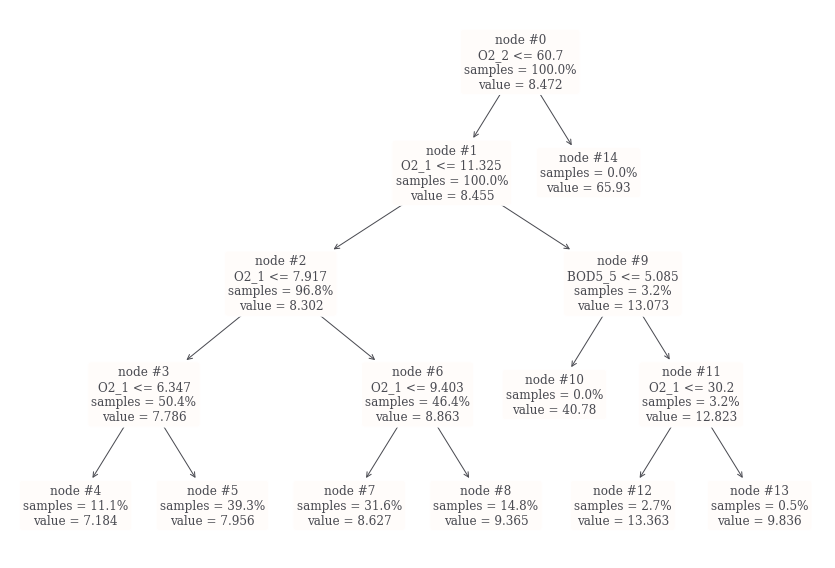

In [19]:
X_train = train.drop("target", axis=1)
y_train = train.target

tree = DecisionTreeRegressor(max_depth=4, random_state=42).fit(X_train, y_train)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11.7, 8), tight_layout=True)
plot_tree(
    decision_tree=tree,
    feature_names=tree.feature_names_in_,
    filled=False,
    rounded=True,
    impurity=False,  # Displays squared error of the node.
    proportion=True,
    node_ids=True,
    ax=ax,
    fontsize=12,
)
plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Decision Process in Tree</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Showing a tree within a depth of $7$ is impossible here, so we have to confine it to a depth of $4$. However, it gives us a little intuition since we see that decisions are made using <code>O2_1</code>, <code>O2_2</code> and <code>BOD5_5</code> features. On a depth of $5$, additionaly the <code>NO2_2</code> and <code>O2_4</code> comes into play to split a specific single nodes. <b>Notice that the initial structure is enforced by the outlier in</b> <code>O2_2</code>. The performance of that tree is not great, not terrible, i.e. RMSE of $1.47$ ($5$-fold CV), where $1.39$ is a decent result in public LB.<br><br>
    I cannot show you the entire tree within a depth of $7$, but I can show you which features are considered during the split. For this we need to get to the tree structure and retrieve this information as below:
</p>

In [20]:
tree = DecisionTreeRegressor(max_depth=7, random_state=42).fit(X_train, y_train)
used_features = np.unique(tree.tree_.feature[tree.tree_.feature != -2])  # -2 means a leaf
used_features = X_train.columns[used_features].to_list()

o2 = slice(0, 7)
nh4 = slice(7, 11)
no2 = slice(11, 14)
no3 = slice(14, 18)
bod5 = slice(18, 22)

print(CLR + "Features used to fit decision tree within depth of 7:\n")
print("O2:  ", *used_features[o2])
print("NH4: ", *used_features[nh4])
print("NO2: ", *used_features[no2])
print("NO3: ", *used_features[no3])
print("BOD5:", *used_features[bod5])


Features used to fit decision tree within depth of 7:

O2:   O2_1 O2_2 O2_3 O2_4 O2_5 O2_6 O2_7
NH4:  NH4_1 NH4_2 NH4_4 NH4_6
NO2:  NO2_2 NO2_6 NO2_7
NO3:  NO3_2 NO3_3 NO3_5 NO3_6
BOD5: BOD5_1 BOD5_3 BOD5_5 BOD5_6


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Decision Process in Tree</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As you can see, on a depth of $7$, the decision tree used $22$ features. Meanwhile, on a depth of $5$, there were $5$ variables. <b>You can see that later, but I can say it now. On a depth of $7$, the random forest used in the competition will be learn from random variables.</b> There are two problems, i.e. too few informative predictors from the task perspective and too deep random forest used in the competition. Probably this is done on purpose. In normal competition, I think that a depth of $4$ or $5$ would be enough.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.2</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Random Variables &amp; Permutation Test</span></b><a class="anchor" id="random_variables_permutation_test"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    We will define a competition model now to utilise and evaluate it in further work. Here, we're going to start by introducing random variables to the dataset. Why? Well, when you introduce random variables to the dataset and train the model, you may check feature importances, for example, based on reduction in the mean squared error (MSE) criterion. <b>When a random variable contributes to the reduction of MSE more than the specific feature available in the dataset, it means that this feature is a noise indeed from the task perspective.</b>
</p>

In [21]:
forest = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)


In [22]:
np.random.seed(42)

X_train["RANDOM_1"] = np.random.normal(size=len(X_train))
X_train["RANDOM_2"] = np.random.normal(size=len(X_train))
X_train["RANDOM_3"] = np.random.normal(size=len(X_train))
X_train["RANDOM_4"] = np.random.normal(size=len(X_train))
X_train["RANDOM_5"] = np.random.normal(size=len(X_train))

forest.fit(X_train, y_train)

importances = (
    pd.DataFrame(
        {
            "Feature": forest.feature_names_in_,
            "Importance": forest.feature_importances_,
        }
    )
    .sort_values(by="Importance", ascending=False)
    .reset_index(drop=True)
)

highest_random_id = importances[importances.Feature.str.startswith("RANDOM")].index[0]
importances = importances.iloc[: highest_random_id + 1]


In [23]:
fig = px.bar(
    importances,
    x="Importance",
    y="Feature",
    color_discrete_sequence=["#6B6A6A"],
    # opacity=0.5,
    height=480,
    width=840,
    title="Feature Importances in Competition Model - Under Reduction in MSE Criterion<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Only five features are more important than random variable</span>",
)
fig.add_annotation(
    x=0.11,
    y=1.8,
    align="left",
    xanchor="left",
    text="<b>Among the 35 available features, only five (from the task perspective)<br>"
    "are more important than the random variable. Moreover, only three<br>"
    "of them are really useful.</b>",
    showarrow=False,
)
fig.update_yaxes(showgrid=False, categoryorder="total ascending", title="")
fig.update_xaxes(showgrid=False)
fig.update_traces(width=0.7)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


In [24]:
mse_vars = importances.Feature[:3].to_list()
print(CLR + "Important features under the reduction in MSE criterion:\n")
print(*mse_vars, sep=", ")


Important features under the reduction in MSE criterion:

O2_1, O2_2, BOD5_5


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Feature Importances via Reduction in MSE</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Normally we should check many seeds and average results, but here we rely on a fixed model, so such an approach is not needed probably. <b>As we can see, in this specific situation, there we have only five variables that are more important than the random one, and only three that are really relevant.</b> If we had defined only one random feature, it could turn out that we've been just lucky that it's important or not. When we define several of them, then we have a more general recognition.</b><br><br>
    As you remember, a simple decision tree on a depth of $7$ used $22$ features from $35$ available. On the other hand, the random forest used in the competition says that the random variable is the $6$th most important one. <b>Conclusion? Such a model is too deep for the task and learns from random numbers. We cannot change the model, but we have to confine features and choose only informative ones.</b><br><br>
    Now we can get to the samples permutation test.
</p>

In [25]:
n_seeds = 5
n_splits = 5

np.random.seed(42)
seeds = np.random.randint(0, 19937, size=n_seeds)


In [26]:
permutation_rmse = defaultdict(list)

for seed in seeds:
    np.random.seed(seed)
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for k, (train_ids, valid_ids) in enumerate(kfold.split(X_train, y_train)):
        X_tk, y_tk = X_train.iloc[train_ids], y_train.iloc[train_ids]
        X_vk, y_vk = X_train.iloc[valid_ids], y_train.iloc[valid_ids]

        forest.fit(X_tk, y_tk)
        rmse = mean_squared_error(y_vk, forest.predict(X_vk), squared=False)

        for i, feature in enumerate(forest.feature_names_in_):
            X_shuffled = X_vk.copy()
            X_shuffled.iloc[:, i] = np.random.permutation(X_shuffled.iloc[:, i])
            rmse_shuffled = mean_squared_error(y_vk, forest.predict(X_shuffled), squared=False)
            # I assume an increase in RMSE if the attribute is essential.
            permutation_rmse[feature].append(((rmse_shuffled - rmse) / rmse) * 100.0)


In [27]:
rmse_increase = (
    pd.DataFrame(permutation_rmse)
    .mean()
    .round(3)
    .sort_values(ascending=False)
    .to_frame(name="Mean RMSE Increase (%)")
    .reset_index(names="Feature")
)

highest_random_id = rmse_increase[rmse_increase.Feature.str.startswith("RANDOM")].index[0]
rmse_increase = rmse_increase.iloc[: highest_random_id + 1]

fig = px.bar(
    rmse_increase,
    x="Mean RMSE Increase (%)",
    y="Feature",
    color_discrete_sequence=["#6B6A6A"],
    # opacity=0.5,
    height=480,
    width=840,
    title="Mean RMSE Increase within Samples Permutation<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Using a 5-fold CV and five different seeds</span>",
)
fig.add_annotation(
    x=9,
    y=3.9,
    align="left",
    xanchor="left",
    text="<b>Sample permutation in the O2_1 feature is ruthless for the target<br>"
    "prediction task. After permutation, RMSE increased by about 52%",
    showarrow=False,
)
fig.update_yaxes(showgrid=False, categoryorder="total ascending", title="")
fig.update_xaxes(showgrid=False)
fig.update_traces(width=0.7)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


In [28]:
permutation_vars = rmse_increase.Feature[:4].to_list()
print(CLR + "Important features under the permutation test:\n")
print(*permutation_vars, sep=", ")


Important features under the permutation test:

O2_1, O2_2, NO2_2, O2_4


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Samples Permutation Test</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In the code above, we explore how rearranging samples within a specific feature affects RMSE when evaluating the validation dataset. To ensure more reliable outcomes, this entire process is repeated with different random seeds. <b>Importantly, throughout this entire process, we shuffle samples in the chosen feature of the validation subset and record results obtained from evaluating this modified dataset in a separate dictionary. If the variable is significant, we should observe worsened results in terms of RMSE.</b><br><br>
    As we can see, the sample permutation in <code>O2_1</code> is completely ruthless regarding target prediction. <b>The RMSE increases by about $50$% when we permute samples there!</b> It means that <code>O2_1</code> is a strong predictor for the target variable. Moreover, this test is more accurate than the reduction in MSE since we evaluate the model on out-of-bag data.<br><br>
    Let's get to the partial dependence plots now.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.3</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Partial Dependence for Features of Interest</span></b><a class="anchor" id="partial_dependence_for_features_of_interest"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Generally, a partial dependence plot (PDP) is another tool for visualizing feature importance. However, this approach differs slightly from the earlier depicted. <b>Here, the partial dependence plot shows the relationship between the model outcome and a particular feature or a set of particular features.</b> In this case, the outcome (partial dependence) is an output of the <code>predict()</code> method. So, it's just a prediction for the <code>target</code> variable. In other words, according to <code>scikit-learn</code> docs: <i>Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.</i><br><br>
    Let's have a look at how it works and how it looks.
</p>

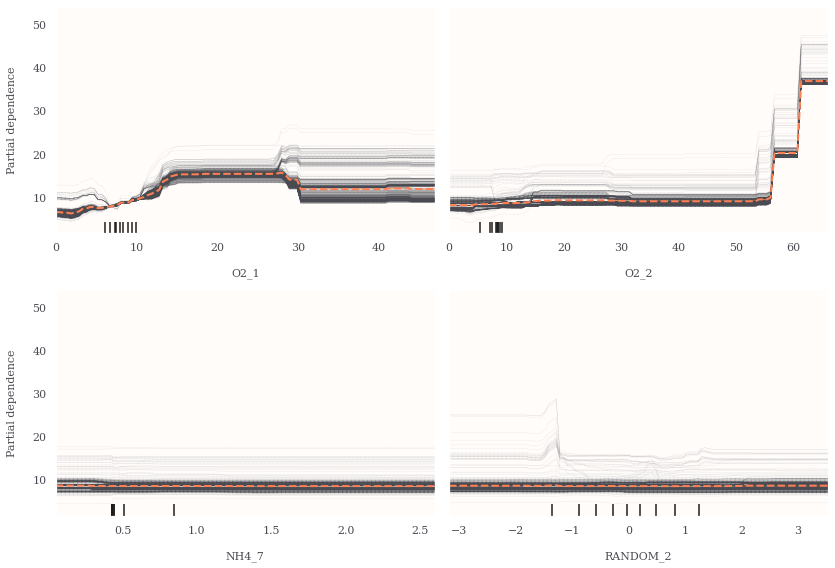

In [29]:
X_ice = X_train[["O2_1", "O2_2", "NH4_7", "RANDOM_2"]]
forest.fit(X_ice, y_train)

fig, axes = plt.subplots(2, 2, figsize=(11.7, 8), tight_layout=True, sharey=True)

PartialDependenceDisplay.from_estimator(
    estimator=forest,
    X=X_ice,
    features=forest.feature_names_in_,
    feature_names=forest.feature_names_in_,
    response_method="auto",  # In regression, the response is `predict()` output.
    kind="both",  # PDP and ICE.
    percentiles=(0, 1),
    random_state=42,
    n_jobs=-1,
    ice_lines_kw={
        "color": "#4A4B52",
        "linewidth": 0.25,
        "alpha": 0.25,
        "linestyle": "--",
    },
    pd_line_kw={"color": "#FF7F51", "linewidth": 2.0},
    ax=axes.ravel(),  # type: ignore
)

for i, ax in enumerate(axes.ravel()):
    ax.get_legend().remove()
    ax.set_xlim(X_ice.iloc[:, i].min(), X_ice.iloc[:, i].max())
    if ax in (axes[0, 1], axes[1, 1]):
        ax.set_ylabel("")

plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Partial Dependence</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here we have PDP visualizations for several features of interest. I selected those four purposefully, i.e. two most important, one which probably introduces noise, and one random one we've created earlier. This way, we can see how different features influence the model, whether it's a linear dependence or not. What is more, one needs to add something. <b>Actually, we've created PDP and individual conditional expectation (ICE) plots. ICE is similar to PDP, but here, the ICE plot shows the dependency of the prediction within a given feature for each sample (it means each black line corresponds to a specific sample).</b><br><br>
    Well, so what do we see here? I describe it using the <code>O2_1</code> feature of interest. Firstly, we need to remember that interactions between features are not included here. It means that we see predictions of the model (partial dependence) depending on only one feature. Concerning the <code>O2_1</code> variable, we can see that initially the output grows as the feature grows, i.e. the dependence is linear in the range $(0, 15)$ of <code>O2_1</code>. On a higher cut-off, the <code>O2_1</code> has virtually no impact on the model, i.e., in the range $(15, 28)$ the dependence is constant. Next, it linearly drops, and again it's constant.<br><br>
    In the case of <code>O2_2</code>, the dependence is virtually all the time constant. Only at the end, it has stepwise dependence (related to the outliers). As for the <code>NH4_7</code>, the dependence is always constant, which means that this feature doesn't introduce any information. Similarly for the random variable and the rest of available features. Now let's have a look at PDP with two input features of interest. That will show us interactions.
</p>

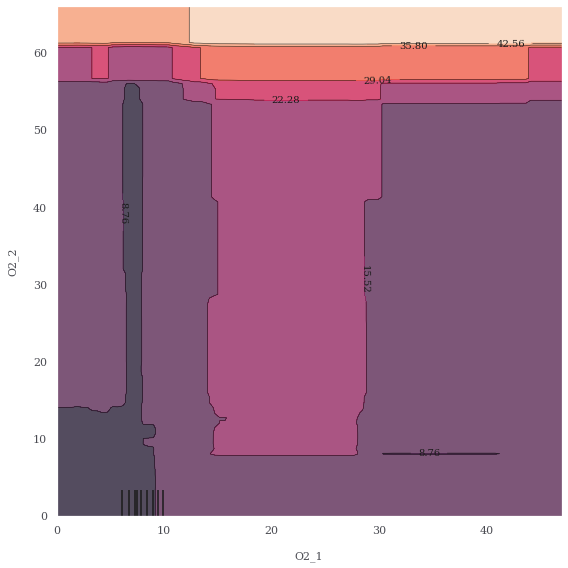

In [30]:
X_ice = X_train[["O2_1", "O2_2"]]
forest.fit(X_ice, y_train)

fig, axes = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True, sharey=True)

PartialDependenceDisplay.from_estimator(
    estimator=forest,
    X=X_ice,
    features=[("O2_1", "O2_2")],
    feature_names=forest.feature_names_in_,
    response_method="auto",  # In regression, the response is `predict()` output.
    kind="average",  # PDP and ICE.
    percentiles=(0, 1),
    random_state=42,
    n_jobs=-1,
    ax=axes,
)

plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Partial Dependence</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The two-variable PDP above shows the dependence of the target variable on joint values of <code>O2_1</code> and <code>O2_2</code>. Here, for example, we can see that if the <code>O2_1</code> is greater than $30$, the main impact on prediction has <code>O2_2</code>, but when <code>O2_1</code> is in the range $(10, 30)$, the situation is diversed.<br><br>
    Well, oxygen measurements from station $1$ and $2$ plays a tremendous role. Can we investigate it better? The answer is yes, using the <code>shap</code> library.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.4</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Feature Importance with SHAP</span></b><a class="anchor" id="feature_importance_with_shap"></a> [↑](#top)

<figure>
    <center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/shap_shapley_values/shap_header.png" alt="SHAP" width=640px></center></br>
    <center><figcaption><b style="font-size: 16px; font-family: 'JetBrains Mono'; color: #4A4B52">Explanation by SHAP. Source: <a href="https://shap.readthedocs.io/en/latest/">SHAP documentation</b></a>.</figcaption></center>
</figure>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <b>SHAP</b> is a specific approach that helps you understand and explain your model's individual predictions. That method is based on <b>Shapley's values</b> from cooperative game theory. The point is that, we can consider prediction process as a game where certain features are players and prediction is a gain. <b>SHAP</b> tells us how to distribute the contribution of each feature into certain prediction fairly using the concept of Shapley values. So, what exactly is a Shapley value? Well, it's an <b>average marginal contribution of a feature value across all possible coalitions of features.</b><br><br>
    But what is the coalition of features? Roughly speaking, the coalition of features is a subset of features that always play in a team. Let's suppose we have three features, <code>F1</code>, <code>F2</code> and <code>F3</code>. When we want to assess the role of feature <code>F3</code> for sample <i>i</i>, we can define a coalition of <code>F1</code>, <code>F2</code> and <code>F3</code>. Subsequently, we draw a sample and evaluate a model. Next, we remove <code>F3</code> from the coalition, which means that we need to swap the value of <code>F3</code> for that drawn sample with a random value from <code>F3</code>. After that, we re-evaluate the model and get a different outcome. We repeat that process many times and for different coalitions, which in the end gives us Shapley value for feature <code>F3</code> and sample <i>i</i>. In other words, <b>the interpretation is that the value of feature $j$ contributed in different coalitions by $\hat{\phi}_j(x)$ to the prediction for this specific observation, in comparison to the average prediction.</b> It's not the difference between predictions when we remove this feature from the dataset.<br><br>
    An explanation of Shapley values deserves a separate notebook. I created one a while ago, which you can find here: <a href="https://www.kaggle.com/code/mateuszk013/ml-explainability-shapley-values-shap"><b>ML Explainability - Shapley Values & SHAP</b></a>. I strongly encourage you to get familiar with this because it allows you to understand Shapley values and how <code>shap</code> works. Generally, this approach is much more sophisticated and tells us about the contribution of features to the model outcome. In other words, what matters and how. As for now, let's get to the work.
</p>

In [31]:
X_full = train.drop("target", axis=1)
y_full = train.target

X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

forest.fit(X_train, y_train);

In [32]:
forest_explainer = explainers.Tree(  # Tree explainer for tree-based model.
    forest,  # Competition random forest.
    data=X_train,  # Background dataset to draw samples in shapley value calculations.
    model_output="raw",  # Explain raw output of the model (output of the predict method).
    feature_perturbation="interventional",  # Or "tree_path_dependent".
    feature_names=forest.feature_names_in_,
)

# Let's explain predictions for 700 valid observations.
shap_values = forest_explainer(X_valid)


 96%|=================== | 675/700 [00:21<00:00]       

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Tree Explainer for Tree-Based Model</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    To get started with <code>shap</code>, we need a training dataset to train a model and validation dataset, for which we want to explain predictions. Comments for particular parameters should be understandable, except the <code>feature_perturbation</code>, which requires much more explanations, which you can read here: <a href="https://www.kaggle.com/code/mateuszk013/ml-explainability-shapley-values-shap"><b>ML Explainability - Shapley Values & SHAP</b></a>. Now I get through several plots from <code>shap</code> library and tell a little what they mean and how to interpret this.
</p>

Number of validation sample: 26


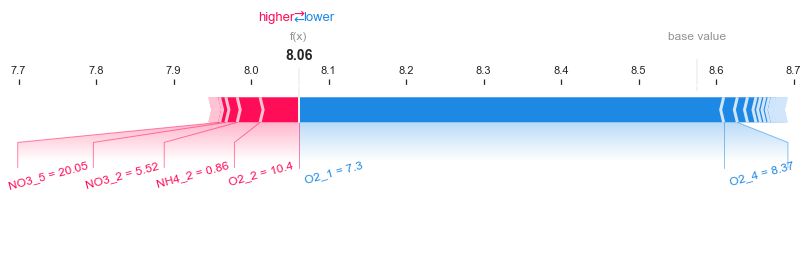

Number of validation sample: 30


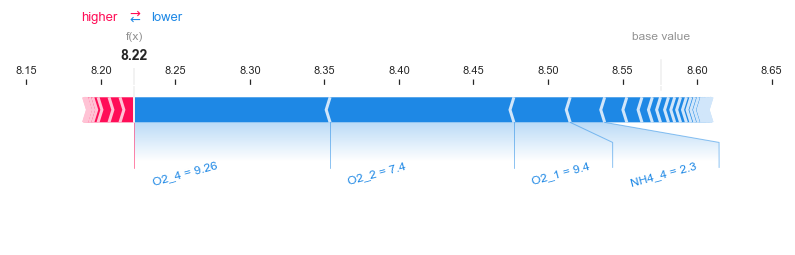

Number of validation sample: 35


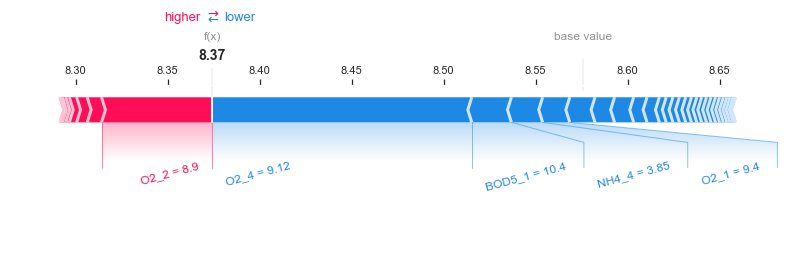

In [33]:
warnings.simplefilter("ignore")
sns.set_theme(
    rc={
        "axes.grid": False,
        "axes.labelsize": 11,
        "axes.facecolor": "white",
        "figure.facecolor": "white",
        "figure.edgecolor": "white",
    }
)

for sample_no in (26, 30, 35):
    print(CLR + "Number of validation sample:", RED + str(sample_no))
    shap.plots.force(
        forest_explainer.expected_value,
        shap_values.values[sample_no],
        features=X_valid.iloc[[sample_no]].round(2),
        matplotlib=True,
        text_rotation=15,
        figsize=(14, 3),
    )


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Force Plots</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The three plots you see above are so-called <code>force</code> plots. <b>Force plot depicts feature contributions (Shapley values) as forces, where each feature can increase or decrease the prediction result</b>. In such a plot, the prediction starts from the baseline, which is the average prediction for the dataset, we passed as the background one. Red arrows push prediction to higher values, meanwhile blue arrows, on the other way around, towards lower values. <b>Remember that these plots above show an explanation for one specific observation.</b> Notice that in the first case, the prediction is smaller than the baseline. The main features that contribute to such a result are <code>O2_1</code> and <code>O2_2</code>. We can see that the <code>O2_1</code> (low value - smaller than the median) pushes prediction towards smaller values. On the other hand, <code>O2_2</code> (large value) pushes it to the higher outcome. Notice that only these two variables play major role. The rest is less important.
</p>

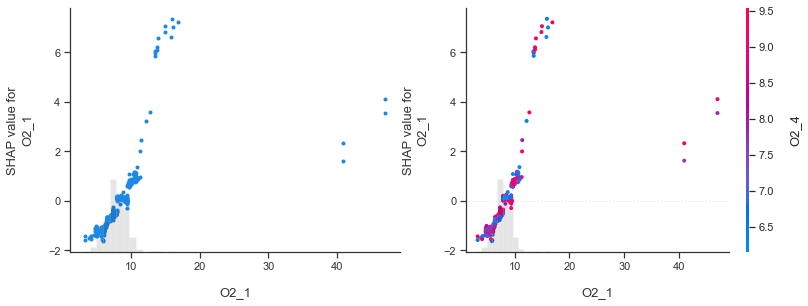

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4.5))
shap.plots.scatter(shap_values[:, "O2_1"], ax=axes[0], show=False)
shap.plots.scatter(shap_values[:, "O2_1"], color=shap_values, ax=axes[1], show=False)
plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Scatter Plots</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This <code>scatter</code> plot is a simple dependence scatter plot. There we have all the single observations we passed to the explainer (observations which need to be explained, not the background dataset) and related to a chosen feature. <b>The x-axis represents the feature value, and the y-axis shows the Shapley value related to that specific sample.</b> Moreover, <code>shap</code> shows distribution of the feature at the bottom of the plot. And that's the plot on the left. The plot on the right needs a more profound explanation. As you can see, there is a vertical dispersion of dots. It means that sometimes the same value of <code>O2_1</code> may have a different impact on prediction depending on the observation. It suggests that there are non-linear interaction effects between <code>O2_1</code> and other features. That's the point. The second plot shows which feature is driving the strongest interaction with <code>O2_1</code>. In this case, it's <code>O2_4</code>.
</p>

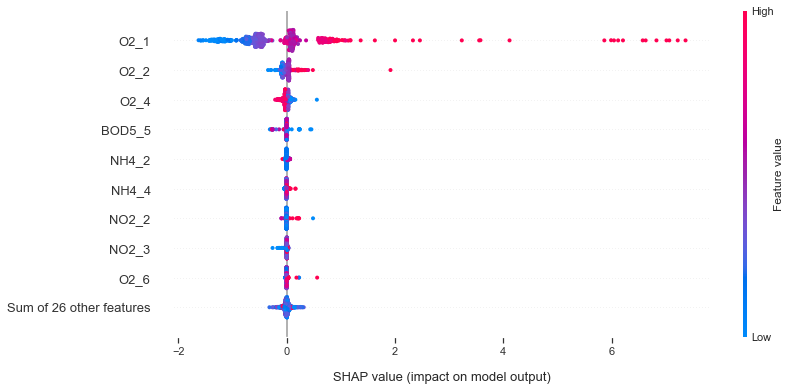

In [35]:
shap.plots.beeswarm(shap_values, plot_size=(12, 6))

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Beeswarm Plot</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    There we have the <code>beeswarm</code> plot. <b>Generally, this kind of plot shows the features' importance with their impact on the model.</b> Each instance we passed to the explainer is represented by a single dot. The position of that dot on the x-axis is specified by the Shapley value. As you can see, these dots resemble something like a distribution of Shapley values. The <code>beeswarm</code> plot accounts for an information summary of how the most important features influence the model output. Features ordering is reflected by the absolute mean Shapley value for each feature. In the case of <code>O2_1</code> and <code>O2_2</code>, the interpretation is simple. If the value of the feature grows, then the feature has a higher and positive contribution to the prediction.
</p>

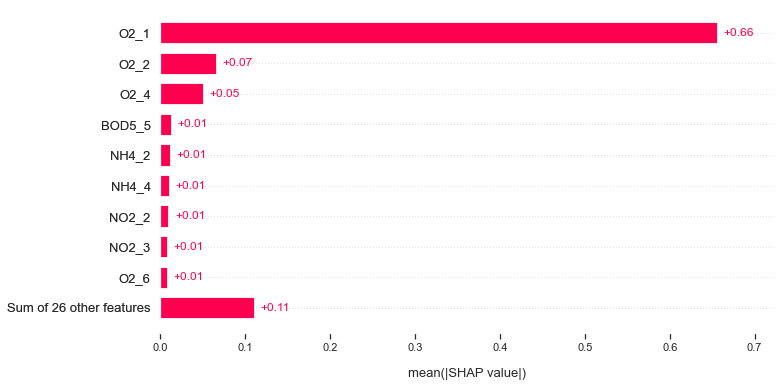

In [36]:
shap.plots.bar(shap_values, show=False)
plt.gcf().set_size_inches(11, 6)
plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Global Bar Plot</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The last type of plot I want to present is the global <code>bar</code> plot. <b>It shows global feature importances, where the feature importance is the mean absolute value of Shapley values for all samples passed to the explainer.</b> Generally, this kind of plot may account for a feature selection method. For example, in this case, only <code>O2_1</code>, <code>O2_2</code> and <code>O2_4</code> matters. The rest is less important.
</p>

In [37]:
shap_vars = ["O2_1", "O2_2", "O2_4"]
print(CLR + "Important features under the SHAP:\n")
print(*shap_vars, sep=", ")


Important features under the SHAP:

O2_1, O2_2, O2_4


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Selected Features</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The last step is to select features as a union from different approaches, and validate default and selected datasets.
</p>

In [38]:
selected_features = sorted(list(set(mse_vars) | set(permutation_vars) | set(shap_vars)))
print(CLR + "Selected features as a union of different methods:\n")
print(*selected_features, sep=", ")


Selected features as a union of different methods:

BOD5_5, NO2_2, O2_1, O2_2, O2_4


In [39]:
default_scores = -cross_val_score(
    forest,
    X=train.drop("target", axis=1),
    y=train.target,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    error_score="raise",
)

selected_scores = -cross_val_score(
    forest,
    X=train[selected_features],
    y=train.target,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    error_score="raise",
)

print(CLR + "5-fold CV RMSE for default dataset: ", RED + f"{default_scores.mean():.5f}")
print(CLR + "5-fold CV RMSE for selected dataset:", RED + f"{selected_scores.mean():.5f}")


5-fold CV RMSE for default dataset:  1.43499
5-fold CV RMSE for selected dataset: 1.41430


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Dimensionality Reduction</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Three different approaches allowed us to select only five essential features that reduce the default 5-fold CV RMSE from $1.43499$ to $1.41430$. <b>In the end, we have $5\big/35$ features that should be informative, and we can get to the outlier detection.</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.5</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Feature Importances Summary</span></b><a class="anchor" id="feature_importances_summary"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>What We Already Know</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>Second section and more conclusions:</b>
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <li>A simple decision tree with a depth of $7$ shows that $22\big/35$ features are used to make a prediction. Meanwhile, a tree with a depth of $5$ uses only $5\big/35$ features.</li>
    <li>Reduction in MSE criterion in random forest and permutation test shows that only about $5\big/35$ features are more important than a random variable. <b>Taking into account the first point, it means that the competition model is too deep, and the dataset contains too few informative features.</b> Without any step, the model will be learned from noise.</li>
    <li>Partial dependence plots show that there is virtually no dependence between the outcome and the feature of interest, for features different than <code>O2_1</code> and <code>O2_2</code>.</li>
    <li>SHAP approach gives us a clue that additionally <code>O2_4</code> may be relatively important.</li>
    <li>In the end, we selected <code>BOD5_5</code>, <code>NO2_2</code>, <code>O2_1</code>, <code>O2_2</code>, <code>O2_4</code> features using three different approaches.</li>
</ul>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In the next section, we will tackle the problem of outliers.</b>
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Outliers Detection</span></b><a class="anchor" id="outliers_detection"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, we will handle the problem of outliers and see which samples contribute the most to the overall error.
</p>

In [40]:
train_selected = train[selected_features].join(train.target)
train_selected.head().style.set_table_styles(DF_STYLE).format(precision=3)


,BOD5_5,NO2_2,O2_1,O2_2,O2_4,target
id,,,,,,
0,16.645,0.050,7.500,9.000,9.265,8.590
1,5.725,1.360,13.533,40.900,9.265,9.100
2,6.750,0.050,3.710,5.420,9.265,8.210
3,8.670,0.050,8.700,8.100,9.200,8.390
4,8.400,0.115,8.050,8.650,9.265,8.070


## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.1</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Isolation Forest vs Performance</span></b><a class="anchor" id="isolation_forest_vs_performance"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Generally, there are several methods available in the <code>scikit-learn</code> library if you ask for the outlier detector, such as <code>SGDOneClassSVM</code>, which is a linear model, <code>LocalOutlierFactor</code>, which is based on nearest neighbours, and <code>IsolationForest</code> based on bagging trees. <b>We will focus on the last one, but I provide a code that you can easily modify to change a detector.</b>
</p>

In [41]:
def remove_outliers(data, method, /, **kwargs):
    if method not in ("IsolationForest", "LocalOutlierFactor", "SGDOneClassSVM"):
        raise ValueError("Unknown detector!")

    detector = getattr(sys.modules[__name__], method)(**kwargs)

    scaler = StandardScaler()  # For LOF and SVM. IsolationForest ignores scaled data.
    data_scaled = scaler.fit_transform(data)

    detector_result = detector.fit_predict(data_scaled)
    outlier_ids = pd.Series(detector_result == -1, index=data.index, dtype=bool)
    data_ids = pd.Series(np.ones_like(data.index), index=data.index, dtype=bool)

    return data[~(outlier_ids & data_ids)]


In [42]:
X_selected = train_selected.drop("target", axis=1)
y_selected = train_selected.target

X_example = remove_outliers(X_selected, "IsolationForest", random_state=42)

print(
    CLR + "Shape before removing outliers:                              ",
    RED + str(X_selected.shape),
)
print(
    CLR + "Shape after removing outliers with default `IsolationForest`:",
    RED + str(X_example.shape),
)


Shape before removing outliers:                               (3498, 5)
Shape after removing outliers with default `IsolationForest`: (3141, 5)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Outlier Detector Function</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The <code>remove_outliers()</code> function above uses one of the chosen methods we talked about earlier to detect and remove outliers from the given dataset. Now, we will perform cross-validation to assess which level of <code>contamination</code> in <code>IsolationForest</code> is the best for the task. <b>We can modify the loop below with different detectors and their hyperparameters.</b>
</p>

In [43]:
np.random.seed(42)

default_rmse = {}
cleaned_rmse = {}

for contamination in (1e-3, 0.01, 0.02, 0.04, 0.08, 0.16):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    for k, (train_ids, valid_ids) in enumerate(kfold.split(X_selected, y_selected)):
        X_train, y_train = X_selected.iloc[train_ids], y_selected.iloc[train_ids]
        X_valid, y_valid = X_selected.iloc[valid_ids], y_selected.iloc[valid_ids]

        X_clean = remove_outliers(
            X_train,
            "IsolationForest",
            contamination=contamination,
            random_state=42,
            n_estimators=1000,
            max_samples=1.0,
            bootstrap=True,
        )
        y_clean = y_train[X_clean.index]

        forest.fit(X_clean, y_clean)
        cleaned_rmse[f"{contamination} - {k + 1}"] = mean_squared_error(
            y_valid, forest.predict(X_valid), squared=False
        )


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Outlier Detection CV</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <b>Here, it is important to remove outliers only in the training subset and validate the model on a non-touched validation dataset.</b> In this way, we simulate how the model trained on a clean dataset behaves on an unseen test dataset (which may have outliers).
</p>

In [44]:
detector_rmse = pd.DataFrame({"KEY": cleaned_rmse.keys(), "RMSE": cleaned_rmse.values()})
detector_rmse[["Contamination", "Fold"]] = detector_rmse.KEY.str.split("-", expand=True)

fig = px.line(
    detector_rmse,
    x="Contamination",
    y="RMSE",
    color="Fold",
    color_discrete_sequence=["#FF7F51"],
    height=640,
    width=840,
    title="Influence of Contamination Hyperparameter on Outliers Removing<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "None of the contamination values reduces RMSE in all folds.</span>",
)
for fold, fold_rmse in enumerate(selected_scores, start=1):
    fig.add_hline(
        fold_rmse,
        annotation_text=f"Fold: {fold}, RMSE: {fold_rmse:.2f}",
        annotation_position="top left",
        annotation_font_size=10,
        line_width=1.5,
        opacity=0.75,
        line_dash="dot",
        line_color="#6B6A6A",
    )
fig.add_annotation(
    x=0.8,
    y=1.9,
    align="left",
    xanchor="left",
    text="<b>If the test dataset resembles Fold 2 or 3, we win.<br>"
    "On the other hand, if it resembles Fold 4, we are lost.</b>",
    showarrow=False,
)
fig.update_traces(line_width=1.5)
fig.update_yaxes(showgrid=False)
fig.update_xaxes(showgrid=False, range=(-1.5, 5))
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    showlegend=False,
    margin_pad=5,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Isolation Forest Contamination</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Gray dashed lines represent the baseline RMSE for a given fold, which we calculated at the end of the second section. Orange lines present RMSE in a given fold depending on <code>contamination</code> in <code>IsolationForest</code>. Unfortunately, none of the <code>contamination</code> values reduces RMSE in all folds. Sometimes, RMSE is lower, sometimes higher than the baseline. <b>This means that we probably cannot rely on</b> <code>IsolationForest</code> <b>and should investigate the remaining methods, or choose a low value (for example $0.001$) of</b> <code>contamination</code> <b>to remove literally several samples.</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.2</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Most Problematic Samples</span></b><a class="anchor" id="most_problematic_samples"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Let's have a look at which samples contribute to the root mean squared error the most. For this, we need to perform cross-validation once more time and gather appropriate results (absolute residuals).
</p>

In [45]:
y_oof = np.zeros_like(y_selected)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for k, (train_ids, valid_ids) in enumerate(kfold.split(X_selected, y_selected)):
    X_train, y_train = X_selected.iloc[train_ids], y_selected.iloc[train_ids]
    X_valid, y_valid = X_selected.iloc[valid_ids], y_selected.iloc[valid_ids]

    forest.fit(X_train, y_train)
    y_oof[valid_ids] = forest.predict(X_valid)


In [46]:
abs_residuals = (
    pd.Series(np.abs(y_selected - y_oof), index=y_selected.index)
    .reset_index()
    .rename(columns={"id": "ID", "target": "Absolute Residual"})
    .sort_values(by="Absolute Residual", ascending=False)
)
abs_residuals.ID = abs_residuals.ID.astype(str)

fig = px.bar(
    abs_residuals[:10],
    x="Absolute Residual",
    y="ID",
    orientation="h",
    color_discrete_sequence=["#6B6A6A"],
    # opacity=0.5,
    height=480,
    width=840,
    title="Most Problematic IDs via Absolute Residuals<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "There are two problematic IDs - 451 and 316</span>",
)
fig.add_annotation(
    x=13,
    y=4.6,
    align="left",
    xanchor="left",
    text="<b>Samples with 451 and 316 IDs contribute to the RMSE the most.<br>"
    "ID 451 contributes by around 18% in total, whereas 316 by around 7%.<br>"
    "In the end, two samples are liable for about 25% of the error.<br></b>",
    showarrow=False,
)
fig.update_yaxes(showgrid=False, categoryorder="total ascending", title="Sample ID")
fig.update_xaxes(showgrid=False)
fig.update_traces(width=0.7)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


In [47]:
mask = (train.index == 451) | (train.index == 316)
train[mask].head().style.set_table_styles(DF_STYLE).format(precision=3)


,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
316,40.780,40.900,40.900,9.500,6.805,5.010,8.760,6.805,0.490,0.395,0.650,4.280,5.144,0.530,0.440,0.060,0.060,0.082,0.805,1.454,0.054,0.075,4.300,5.125,4.660,5.900,9.805,4.530,4.420,4.800,3.500,4.650,6.025,5.070,3.850,4.140
451,65.930,40.950,65.950,9.265,6.625,5.010,8.370,6.375,0.710,0.600,0.650,5.848,5.124,0.429,0.429,0.054,0.026,0.120,0.902,0.848,0.071,0.567,1.325,1.325,2.095,4.900,7.795,1.730,1.780,4.100,4.645,4.725,5.725,10.645,3.025,3.800


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Residual Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The above test shows that there are two most problematic samples in the dataset, responsible for the major contribution to the total error. <b>These are $451$ and $316$. As you can see, these samples have the highest target values and the competition random forest doesn't handle them well.</b> Now is the question of whether these two observations are outliers (not related to the general distribution) as we thought at the beginning or are derived from the same distribution but with extremely small probability. Well, hard to say. <b>If these derive from the same distribution, we should leave them as they are because the hidden test dataset probably also contains such samples. On the other hand, if these are true outliers, we should drop them.</b> As for now, I leave this problem as it is.</b><br><br>
    The last thing I want to see here is the problem of duplicated samples. 
</p>

In [48]:
print(
    CLR + "Duplicated samples:                  ",
    RED + str(train_selected.duplicated().sum()),
)
print(
    CLR + "Duplicated samples regardless target:",
    RED + str(train_selected.duplicated(selected_features).sum()),
)


Duplicated samples:                   26
Duplicated samples regardless target: 118


In [49]:
def remove_duplicates(data, subset=None):
    return data[~data.duplicated(subset)]


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #FF7F51;
">
    <b>Duplicated Samples</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In the selected dataset, we have $26$ duplicated observations and $118$ ones regardless of the target. We can remove such ones.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">4</span> <span style='color: #FF7F51'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Summary</span></b><a class="anchor" id="summary"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    That's probably all in this notebook, but who knows? There is no reflection in the CV on LB, so it's probably best to leave this as it is, i.e. select only the most informative features, remove outliers with a low value of contamination and lastly, remove duplicates. In such a case, we should rely on the local CV only and ignore public LB since there is a huge standard deviation in the CV scheme.
</p>

In [50]:
sub = (
    train[selected_features]
    .pipe(
        remove_outliers,
        "IsolationForest",
        contamination=1e-3,
        random_state=42,
        n_estimators=1000,
        max_samples=1.0,
        bootstrap=True,
    )
    .pipe(remove_duplicates)
)

submission = pd.DataFrame(sub, columns=train.columns).fillna(0)
submission.target = train.target[sub.index]

submission.to_csv("submission.csv")
submission.head().head().style.set_table_styles(DF_STYLE).format(precision=3)


,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8.590,7.500,9.000,0.000,9.265,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,16.645,0.000,0.000
1,9.100,13.533,40.900,0.000,9.265,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.360,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.725,0.000,0.000
2,8.210,3.710,5.420,0.000,9.265,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.750,0.000,0.000
3,8.390,8.700,8.100,0.000,9.200,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.670,0.000,0.000
4,8.070,8.050,8.650,0.000,9.265,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.400,0.000,0.000


In [51]:
print(CLR + "Submission shape:", RED + f"{submission.shape}")


Submission shape: (3376, 36)


<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    I hope you like it, and if yes, then leave an upvote. If you have any questions, let me know in the comments section. Moreover, I encourage you to check my other notebooks, especially these: <a href="https://www.kaggle.com/code/mateuszk013/neural-machine-translation-with-attention"><b>Neural Machine Translation with Attention</b></a> and <a href="https://www.kaggle.com/code/mateuszk013/ml-explainability-shapley-values-shap"><b>ML Explainability - Shapley Values & SHAP</b></a>. These are important to me. Thanks and good luck!
</p>